In [78]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import time
from scipy import stats

In [79]:
def show_graph(adj_matrix, clique):
    graph = nx.from_numpy_matrix(adj_matrix)
    subgraph = graph.subgraph(clique)
    nx.draw(subgraph, with_labels=True)
    plt.axis('equal')
    
def import_graph(filepath):
    graph = None
    f = open(filepath, 'r')
    lines = f.readlines()
    for i in lines:
        line = i.strip('\n').split(' ')
        if line[0] == 'p':
            line = list(filter(None, line)) 
            print(line)
            graph = np.zeros((int(line[2]), int(line[2])), dtype = int)
        elif line[0] == 'e':
            graph[int(line[1])-1][int(line[2])-1] = 1
            graph[int(line[2])-1][int(line[1])-1] = 1
            
    return graph
        


In [80]:
def initialize_population(adj_matrix, pop_size):
    population = []
    
    for i in range(0, pop_size):
        individual = []
        random_node = pick_node(adj_matrix)
        neighbors = get_neighbors(random_node, adj_matrix)
        individual = find_clique(neighbors, random_node, adj_matrix)
        population.append(individual)
    return population

def get_neighbors(node, adj_matrix):
    connections = adj_matrix[node-1]
    
    neighbors = []
    for i in range(0, len(connections)):
        if connections[i] == 1:
            neighbors.append(i+1)
    
    return neighbors

def pick_node(adj_matrix):
    return random.randrange(len(adj_matrix))

def find_clique(node_list, point, adj_matrix):
    clique = [point]
    degrees = get_degrees(node_list, adj_matrix)
    sorted_deg = sorted(degrees, key=lambda x: x[1], reverse=True)
    nodes = [i[0] for i in sorted_deg]
    for i in nodes:
        connected = True
        for j in clique:
            if adj_matrix[i-1][j-1] == 0:
                connected = False
                break
        if connected:
            clique.append(i)
    
    return clique

#TODO: Why are cliques not fully connected? Test everything below this line
def improve_clique(clique, chromosome, adj_matrix):
    new_clique = clique
    idx = random.randrange(len(chromosome))
    for i in range(idx-1, len(chromosome)):
        if i not in new_clique:
            temp = clique
            temp.append(i)
            if fully_connected(temp, adj_matrix):
                new_clique.append(i)
    return new_clique
    
def fully_connected(node_list, adj_matrix):
    connected = True
    for i in node_list:
        for j in node_list:
            if i != j:
                if adj_matrix[i-1][j-1] == 0:
                    connected = False
                    break
    return connected

def rank_pop_elite(population, gen_size):
    fitness_scores = []
    
    for i in population:
        fitness_scores.append(len(i))  
        
    scored = zip(population, fitness_scores)
    sorted_pop = sorted(scored, key=lambda x: x[1], reverse=True)
    to_breed = []
    for i in sorted_pop[:gen_size]:
        to_breed.append(i[0])
        
    return to_breed

def breed(parent1, parent2, adj_matrix):
    #Combine subgraphs
    candidate_child = parent1 + parent2
    
    #Get random point in child
    child_point = pick_node(candidate_child)
    
    #Find clique involving child point
    child = find_clique(candidate_child, child_point, adj_matrix)
    #child = improve_clique(child, candidate_child, adj_matrix)
    
    #Return child clique
    return child

def breed_pop(pool, size, adj_matrix):
    children = []
    
    for i in pool:
        children.append(i)
        
    while len(children) < size:
        parents = random.sample(pool, 2)
        child = breed(parents[0], parents[1], adj_matrix)
        children.append(child)
    return children

#TODO: Implement Mutation
def mutate(individual, adj_matrix):
    random_node = pick_node(individual)
    #neighbors = get_neighbors(random_node, adj_matrix)
    individual[random_node-1] = random.randrange(len(adj_matrix))
    clique = find_clique(individual, random_node, adj_matrix)
    
    return clique

def mutate_population(population, mut_rate, adj_matrix):
    new_pop = []
    for i in population:
        chance = random.random()
        if chance <= mut_rate:
            new_pop.append(mutate(i, adj_matrix))
        else:
            new_pop.append(i)
    return new_pop
            
def make_generation(curr_gen, pop_size, pool_size, mut_rate, adj_matrix):
    pop_to_breed = rank_pop_elite(curr_gen, pool_size)
    new_generation = breed_pop(pop_to_breed, pop_size, adj_matrix)
    new_generation = mutate_population(new_generation, mut_rate, adj_matrix)
    return new_generation

def find_fitnesses(generation):
    fitness = []
    for i in generation:
        fitness.append(len(i))
    return fitness

def run_ga_clique(adj_matrix, num_generations, pop_size, pool_size, mut_rate):
    start_time = time.time()
    
    best_gen_fit_list = []
    gen_cliques = []
    
    pop = initialize_population(adj_matrix, pop_size)
    
    for i in range(0, num_generations):
        if (i+1)%25 == 0:
            print("Generation: " + str(i+1))
        next_generation = make_generation(pop, pop_size, pool_size, mut_rate, adj_matrix)
        fitnesses = find_fitnesses(next_generation)
        
        best_gen_fit = 0
        best_gen_clique = None
        
        for j in next_generation:
            if len(j) > best_gen_fit:
                best_gen_fit = len(j)
                best_gen_clique = j
         
        best_gen_fit_list.append(best_gen_fit)
        gen_cliques.append(best_gen_clique)
        
    
    return (best_gen_fit_list, gen_cliques)

def get_degrees(clique, adj_matrix):
    degrees = []
    for i in clique:
        count = 0
        for j in clique:
            if adj_matrix[i-1][j-1] == 1:
                count +=1
        degrees.append((i, count))
    return degrees

In [81]:
adj_matrix = import_graph('DIMACS_all_ascii/p_hat300-1.clq')
print(adj_matrix)

pop = initialize_population(adj_matrix, 2)

['p', 'edge', '300', '10933\t']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]


['p', 'edge', '300', '10933\t']
Running GA 0...
Generation: 25
Generation: 50
Generation: 75
Generation: 100
Generation: 125
Generation: 150
Generation: 175
Generation: 200
Largest Clique Size: 
8
Largest Clique: 
[0, 96, 23, 227, 211, 174, 218, 227]
Clique Size Statistics: 
DescribeResult(nobs=201, minmax=(8, 8), mean=8.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
Time Statistics: 
DescribeResult(nobs=1, minmax=(4.793943881988525, 4.793943881988525), mean=4.793943881988525, variance=nan, skewness=0.0, kurtosis=-3.0)


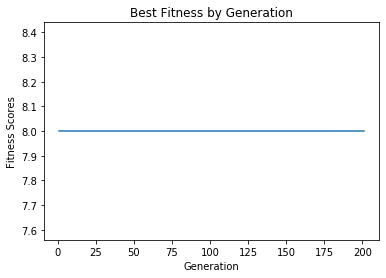

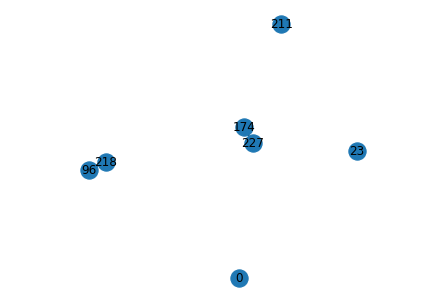

In [82]:
adj_matrix = import_graph('DIMACS_all_ascii/p_hat300-1.clq')


fits = []
times = []
best_fit = 0
best_clique = None
all_cliques = []

#Run ga algorithm 15 times
for i in range(0,1):
    start_time = time.time()
    print("Running GA " + str(i) + "...")
    fits, cliques = run_ga_clique(adj_matrix, 200, 200, 10, 0.1)
    run_time = time.time()-start_time
    
    max_fit = max(fits)
    max_fit_idx = fits.index(max(fits))
    clique = cliques[max_fit_idx]
    
    times.append(run_time)
    all_cliques.append(clique)
    fits.append(max_fit)
    if max_fit > best_fit:
        best_fit = max_fit
        best_clique = clique
        
#Print results
print("Largest Clique Size: ")
print(best_fit)
print("Largest Clique: ")
print(best_clique)
print("Clique Size Statistics: ")
print(stats.describe(fits))
print("Time Statistics: ")
print(stats.describe(times))

plt.plot(range(1, len(fits)+1), fits)
plt.title("Best Fitness by Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness Scores")
plt.show()

show_graph(adj_matrix, best_clique)

In [83]:
graph = nx.from_numpy_matrix(adj_matrix)
subgraph = graph.subgraph(best_clique).copy()
print(best_clique)
print(find_clique(best_clique, best_clique[0], adj_matrix))
print(list(subgraph.degree(list(subgraph.nodes))))
print(adj_matrix[14, 60])
print(fully_connected(best_clique, adj_matrix))
print(graph.has_edge(108, 151))

[0, 96, 23, 227, 211, 174, 218, 227]
[0, 174]
[(0, 0), (96, 1), (227, 1), (174, 1), (211, 0), (23, 0), (218, 1)]
0
False
False
